<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Homework 5: Regression Modeling to Forecast Bike Sharing Usage, Continued

**Clemson University**<br>
**Fall 2021**<br>
**Instructor(s):** Nina Hubig <br>


---



In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

<img src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/BSS.png">

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [73]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

---

<div class="theme">  Getting Started </div>

**NOTE:** This homework assignment is a continuation of Homework 4. 

Load `BSS_train.csv` and `BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday`, `casual`, and `registered` columns from both the train and the test dataset. 

In [3]:
# Your code here
BSS_train = pd.read_csv("BSS_train.csv")
BSS_test = pd.read_csv("BSS_test.csv")
Bikes_df_raw = pd.read_csv("BSS_hour_raw.csv")


In [18]:
BSS_train = BSS_train.drop(['dteday','casual','registered'], axis=1)
BSS_test = BSS_test.drop(['dteday','casual','registered'], axis=1)



In [20]:
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,63,0,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,479,0,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,353,0,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,411,1,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,70,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
BSS_train['temp'].head()

0    0.24
1    0.62
2    0.76
3    0.62
4    0.18
Name: temp, dtype: float64

---

<div class="theme">  Question 3 - Multiple Linear Regression to Predict Hourly Ridership </div>

<div class='exercise'> <b> Question 3.1 </b> </div>

Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`. Reminder that you need to add a constant column when using statsmodels in order to fit the intercept.

In [54]:
# multiple linear regression
X_train = sm.add_constant(BSS_train.drop('counts', axis=1))
X_test = sm.add_constant(BSS_test.drop('counts', axis=1))
Y_train = BSS_train['counts'].values.reshape(-1,1)
Y_test = BSS_test['counts'].values.reshape(-1,1)

model = OLS(Y_train, X_train)
results = model.fit()

y_hat_train = results.predict()
y_hat_test = results.predict(exog=X_test)

print('Parameters: \n', results.params)

Parameters: 
 const         -30.407500
hour            7.209247
holiday       -19.151036
year           78.121108
workingday     10.948441
temp          273.662515
atemp         162.535266
hum          -202.008009
windspeed      19.382705
spring         50.075412
summer         22.687920
fall           70.947417
Feb           -10.719770
Mar           -11.293840
Apr           -44.832594
May           -50.160547
Jun           -72.204151
Jul           -90.896453
Aug           -58.324552
Sept          -16.168637
Oct           -15.883815
Nov           -32.723179
Dec           -19.208751
Mon            -3.333610
Tue            -0.007375
Wed            -2.205852
Thu            -5.569800
Fri             2.914043
Sat            12.746077
Cloudy          6.916314
Snow          -26.815450
Storm          48.204539
dtype: float64


In [62]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:39:53   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

In [114]:
print('train r2 = {:.4}'.format( r2_score(BSS_train['counts'], y_hat_train)))
print('test r2 = {:.4}'.format(r2_score(BSS_test['counts'], y_hat_test)))

train r2 = 0.4116
test r2 = 0.4007


<div class='exercise'> <b> Question 3.2 </b> </div>

Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

In [116]:
# Your code here
results.pvalues[((results.pvalues < 0.05) & (results.params > 0))]

hour          6.967036e-200
year          3.862196e-142
workingday     1.828978e-03
temp           9.243128e-06
atemp          1.229662e-02
spring         1.510519e-07
summer         4.168321e-02
fall           6.554799e-14
Sat            2.255964e-02
dtype: float64

In [115]:
results.pvalues[((results.pvalues < 0.05) & (results.params < 0))]

const      5.319401e-03
holiday    2.214061e-02
hum        5.926590e-90
Apr        3.897799e-04
May        2.023805e-04
Jun        1.392848e-07
Jul        3.606677e-09
Aug        1.084419e-04
Nov        6.623427e-03
Dec        4.454012e-02
Snow       1.092443e-05
dtype: float64

<div class='exercise'> <b> Question 3.3 </b> </div>

You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

*Your answer here*


It implies negative correlation and it's relation is statistically insignificant. Here the independent variable might increases, the dependent variable might tends to decrease.

<div class='exercise'> <b> Question 3.4 </b> </div>

To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

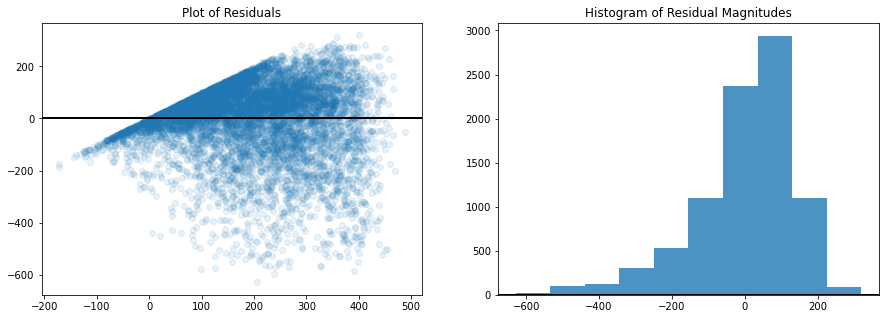

In [78]:
# Your code here
fig, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, y_hat_train - Y_train[:,0], alpha=0.1)
axes[0].axhline(0, c='black', lw=2)

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(y_hat_train - Y_train[:,0], alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
plt.show()

*Your answer here*

As y-hat increases, the variance of the residuals also increases. There is also a pattern to the residuals, suggesting more than linear behavior needs modeling. Hence, linear regression is a bad fit for this data


<div class='exercise'> <b> Question 3.5 </b> </div>

Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [117]:
X_train_poly = X_train.copy()
X_train_poly['hour2'] = X_train_poly['hour']**2
X_train_poly['temp'] = X_train_poly['temp']**2
X_train_poly['hum2'] = X_train_poly['hum']**2
X_train_poly.head()
x = sm.add_constant(X_train_poly)
poly_model = OLS(endog = Y_train, exog = x, hasconst = True).fit()
poly_model_prediction = poly_model.predict(X_train_poly)
X_train.columns

Index(['const', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

<class 'pandas.core.series.Series'>


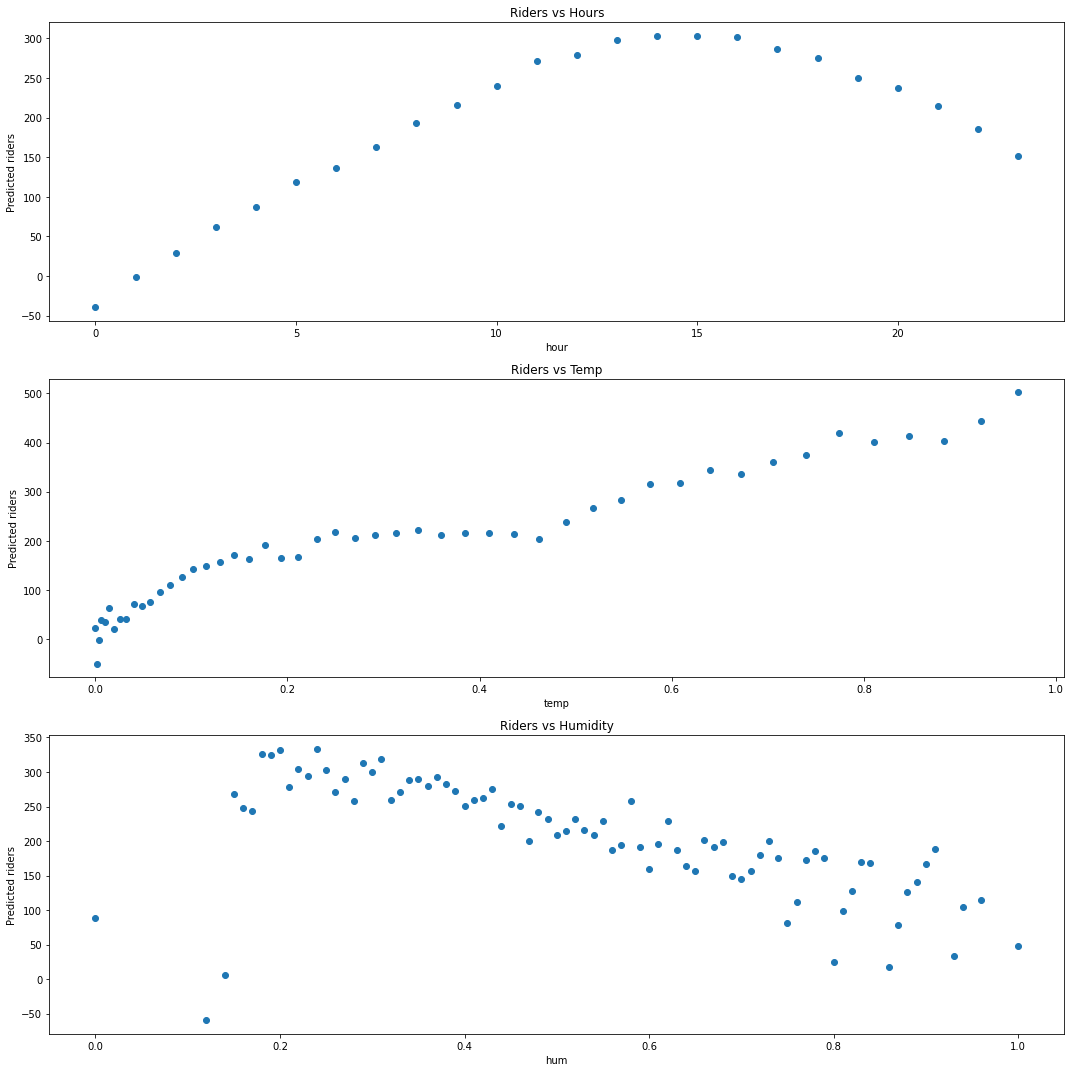

In [118]:
cor_columns = ['hour', 'temp', 'hum']

fig, ax = plt.subplots(3, figsize = (15,15))
title_array = ['Riders vs Hours', 'Riders vs Temp', 'Riders vs Humidity']
print(type(X_train_poly['hour']))
for i in range(len(cor_columns)):
    new_db = X_train_poly
    new_db['count'] = poly_model_prediction
    new_db = new_db.groupby(cor_columns[i]).mean().reset_index()
    
    rects1 = ax[i].scatter(new_db[cor_columns[i]], new_db['count'])
    
    ax[i].set_xlabel(cor_columns[i])
    ax[i].set_ylabel('Predicted riders')
    ax[i].set_title(title_array[i])
    
fig.tight_layout()
plt.show()

*Your answer here*

From the graphs above, the ridership in a day and temperatur show a significant positive or nonlinear impact on bicycling, while Humidity has a moderate negative impact on ridership.

<div class='exercise'> <b> Question 3.6 </b> </div>

You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.

In [87]:
# Your code here
X_train_drop=X_train[['const','hour','holiday','year','temp','hum','windspeed','Feb','Mar', 'Apr',
                      'May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','spring','Mon','Tue',
                      'Wed','Thu','Fri','Sat','Cloudy','Snow','Storm']]
X_train_drop=sm.add_constant(X_train_drop)
model=OLS(endog=Y_train,exog=X_train_drop,hasconst=True).fit()
model.summary()






<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     220.0
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:37:06   Log-Likelihood:                -55250.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8661   BIC:                         1.108e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.0042     10.757     -2.417      0.016     -47.091      -4.917
hour           7.2029      0.234     30.830      0.000       6.745       7.661
holiday      -37.1695      9.377     -3.964      0.000     -55.550     -18.789
year          77.6699      3.031     25.624      0.000      71.728      83.612
temp         430.2041     16.925     25.418      0.000     397.027     463.381
hum         -199.2249      9.931    -20.060      0.000    -218.693    -179.757
windspeed      3.0755     13.147      0.234      0.815     -22.696      28.847
Feb          -10.6710      7.613     -1.402      0.161     -25.594       4.252
Mar           -8.8311      8.277     -1.067      0.286     -25.055       7.393
Apr          -34.8773     11.605     -3.005      0.003     -57.625     -12.129
May          -43.4220     12.643     -3.434      0.001     -68.206     -18.638
Jun          -63.2655     11.993     -5.275      0.000     -86.776     -39.756
Jul          -74.8504     11.578     -6.465      0.000     -97.546     -52.155
Aug          -43.1533     11.036     -3.910      0.000     -64.786     -21.520
Sept          14.2565     10.050      1.418      0.156      -5.445      33.958
Oct           52.9882      8.677      6.107      0.000      35.980      69.996
Nov           37.7815      7.785      4.853      0.000      22.520      53.043
Dec           25.9209      7.571      3.423      0.001      11.079      40.763
spring        39.3742      7.777      5.063      0.000      24.130      54.618
Mon            9.0752      5.795      1.566      0.117      -2.283      20.434
Tue           11.6160      5.697      2.039      0.041       0.448      22.784
Wed            8.2531      5.668      1.456      0.145      -2.858      19.364
Thu            5.7258      5.633      1.016      0.309      -5.317      16.769
Fri           13.3911      5.632      2.378      0.017       2.352      24.431
Sat           11.9456      5.607      2.131      0.033       0.955      22.936
Cloudy         6.6667      3.688      1.808      0.071      -0.562      13.896
Snow         -28.1551      6.105     -4.612      0.000     -40.122     -16.188
Storm         45.4112     99.207      0.458      0.647    -149.058     239.881
==============================================================================
Omnibus:                     1707.399   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3290.114
Skew:                           1.200   Prob(JB):                         0.00
Kurtosis:                       4.824   Cond. No.                         898.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Your answer here*

Multicollinearity occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent. If the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results. The coefficient values can lead to errors based on the other independent variables in the model. The coefficients are very sensitive to small changes in the model.

---

<div class="theme">  Question 4 - Regression Models with Polynomial and Interaction Terms </div>

<div class='exercise'> <b> Question 4.1 </b> </div>

Drop the variables `workingday`, `atemp`, `spring`, `summer`, and `fall` from `BSS_train` (if any of them still remain).

In [100]:
# Your code here

BSS_train.head()


,hour,holiday,year,temp,hum,windspeed,counts,Feb,Mar,Apr,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,0.24,0.60,0.2537,63,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,0.62,0.83,0.2537,479,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,0.76,0.66,0.1642,353,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0.62,0.22,0.2985,411,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0.18,0.40,0.1343,70,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class='exercise'> <b> Question 4.2 </b> </div>

Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`

In [96]:
# Your code here
def standardize_cols(cols, df_train, df_test):
    return_train = df_train.copy().reset_index().drop("index", axis=1)
    return_test = df_test.copy().reset_index().drop("index", axis=1)
    
    df_train=df_train[cols]
    df_test=df_test[cols]
    
    scaler=StandardScaler().fit(df_train)
    
    train_scaled=pd.DataFrame(scaler.transform(df_train), columns=cols)
    test_scaled=pd.DataFrame(scaler.transform(df_test), columns=cols)
    
    for col in train_scaled.columns:
        return_train[col]=train_scaled[col]
        return_train[col]=train_scaled[col]
        
    return return_train, return_test


        

In [98]:
binary_columns=[ 'const','holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']
nonbinary_columns=X_train.columns.difference(binary_columns)
practice_X_train=X_train[nonbinary_columns]

practice_X_train_scaled, practice_X_test_scaled=standardize_cols(nonbinary_columns,X_train,BSS_test)
practice_X_test_scaled.describe()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,...,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000
mean,11.495972,0.028193,0.501726,0.682394,0.497570,0.476151,0.629201,0.189580,188.544764,0.257077,...,0.085386,0.141082,0.144419,0.143038,0.139816,0.142232,0.143038,0.265362,0.079977,0.000115
std,6.868329,0.165534,0.500026,0.465572,0.192561,0.171717,0.193568,0.121426,181.348797,0.437047,...,0.279471,0.348126,0.351534,0.350132,0.346816,0.349308,0.350132,0.441551,0.271273,0.010727
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.030300,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,40.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,141.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.790000,0.253700,276.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,976.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<div class='exercise'> <b> Question 4.3 </b> </div>

Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

In [99]:
print(practice_X_train_scaled.columns)
def higher_order(df_scaled, degree, cols):
    df=df_scaled.copy()
    for col in cols:
        for i in range(2, degree+1):
            df['{}^{}'.format(col, i)]=df[col]**i
    return df
higher_order_feat=["temp","hum","windspeed","hour"]

practice_X_train_poly=higher_order(practice_X_train_scaled, 2, higher_order_feat)
practice_X_train_poly.head()

Index(['const', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')


,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,...,Thu,Fri,Sat,Cloudy,Snow,Storm,temp^2,hum^2,windspeed^2,hour^2
0,1.0,1.350966,0,0.993233,1,-1.331629,-1.442584,-0.131358,0.511860,0,...,1,0,0,1,0,0,1.773236,0.017255,0.262001,1.825110
1,1.0,0.776238,0,-1.006813,1,0.641888,0.583783,1.064879,0.511860,0,...,1,0,0,0,1,0,0.412021,1.133967,0.262001,0.602545
2,1.0,-0.373220,0,0.993233,1,1.368974,1.464686,0.180704,-0.214334,0,...,1,0,0,0,0,0,1.874089,0.032654,0.045939,0.139293
3,1.0,0.776238,0,0.993233,0,0.641888,0.759963,-2.107748,0.875363,1,...,0,0,0,0,0,0,0.412021,4.442601,0.766260,0.602545
4,1.0,-0.516902,0,0.993233,0,-1.643237,-1.618765,-1.171563,-0.456939,0,...,0,0,0,0,0,0,2.700228,1.372560,0.208794,0.267188


<div class='exercise'> <b> Question 4.4 </b> </div>

Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

In [103]:
# Your code here
continuous_predictors=["temp","hum","windspeed"]
dummies=['Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def higher_order_dummies(df,continuous,dummies):
    df_copy=df.copy()
    column_names_final=[]
    for a in continuous:
        for b in dummies:
            column_names_final.append(a+" "+b)
            df_copy[a+" "+b]=df_copy[a]*df_copy[b]
    return df_copy
return_df=higher_order_dummies(BSS_train,continuous_predictors,dummies)
practice_X_train_poly=pd.concat([practice_X_train_poly[practice_X_train_poly.columns.difference(return_df.columns)],return_df], axis = 1)
practice_X_train_poly.head()

,atemp,const,fall,hour^2,hum^2,spring,summer,temp^2,windspeed^2,workingday,...,windspeed Sept,windspeed Oct,windspeed Nov,windspeed Dec,windspeed Mon,windspeed Tue,windspeed Wed,windspeed Thu,windspeed Fri,windspeed Sat
0,-1.442584,1.0,0,1.825110,0.017255,0,0,1.773236,0.262001,1,...,0.0,0.0000,0.0,0.2537,0.0,0.0,0.0,0.2537,0.0,0.0
1,0.583783,1.0,1,0.602545,1.133967,0,0,0.412021,0.262001,1,...,0.0,0.2537,0.0,0.0000,0.0,0.0,0.0,0.2537,0.0,0.0
2,1.464686,1.0,0,0.139293,0.032654,0,1,1.874089,0.045939,1,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.1642,0.0,0.0
3,0.759963,1.0,0,0.602545,4.442601,1,0,0.412021,0.766260,0,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
4,-1.618765,1.0,0,0.267188,1.372560,0,0,2.700228,0.208794,0,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0


<div class='exercise'> <b> Question 4.5 </b> </div>

Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [119]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    train_df = train_df.reset_index().drop('index', axis = 1)
    val_df = val_df.reset_index().drop('index', axis = 1)
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    x_train = train_df.drop(bad_columns, axis = 1)
    x_val = val_df.drop(bad_columns, axis = 1)
    
    nonbinary_columns = x_train.columns.difference(binary_columns)
    
    x_train, x_val = standardize_cols(nonbinary_columns, x_train, x_val)
    
    x_train = higher_order(x_train, degree, columns_forpoly)
    x_val = higher_order(x_val, dgree, columns_forpoly)
    
    dummy_cols = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    
    continuous_pred = ['temp', 'hum', 'windspeed']
    
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    # Add code here
    x_train=higher_order_dummies(x_train,continous_pred, dummy_cols)
    x_val=higher_order_dummies(X_val, continous_pred, dummy_cols)
    
    x_train["const"]=1
    x_val["const"]=1
    return x_train,y_train, x_val,y_val
    return x_train,y_train, x_val,y_val


<div class='exercise'> <b> Question 4.6 </b> </div>

For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

In [106]:
"""
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """

train_r2_score = r2_score(y_train, BikeOLSModel.predict(X_train))
test_r2_score = r2_score(y_test, BikeOLSModel.predict(X_test))
print("Train Set R^2 Score: {:.4f}".format(train_r2_score))
print("Test Set R^2 Score: {:.4f}".format(test_r2_score))

BikeOLS_r2scores = {}
BikeOLS_r2scores['training'] = train_r2_score
BikeOLS_r2scores['test'] = test_r2_score    

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 31 is different from 32)

<div class='exercise'> <b> Question 4.7 </b> </div>

Discuss patterns you see in the results from 4.5. Which model would you select, and why?

*Your answer here*

<div class='exercise'> <b> Question 4.8 </b> </div>

Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

*Your answer here*

---

<div class="theme">  Question 5 - Regularized Models </div>

<div class='exercise'> <b> Question 5.1 </b> </div>

Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, using your `get_design_mats` function, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

In [111]:
# Your code here
# your code here
from sklearn.model_selection import KFold
lambdas = [.01, .05, 1, 5, 10, 50, 100]
fold = KFold(5, shuffle=True)

In [113]:
# your code here
# RidgeCV
BikeRRModel = RidgeCV(cv=5, alphas=lambdas, fit_intercept=True)

BikeRRModel.fit(X_train, y_train) 

BikeRR_shrinkage_parameter = BikeRRModel.alpha_

Ridge_coefficients = BikeRRModel.coef_.ravel()

<div class='exercise'> <b> Question 5.2 </b> </div>

Find the best-scoring degree and regularization combination.

In [ ]:
# Your code here

<div class='exercise'> <b> Question 5.3 </b> </div>

It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

In [ ]:
# Your code here

*Your answer here*

<div class='exercise'> <b> Question 5.4 </b> </div>

Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

In [121]:
# Your code here
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]
fold = KFold(5, shuffle=True)

<div class='exercise'> <b> Question 5.5 </b> </div>

Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

In [122]:
# Your code here
si= np.argsort(np.abs(BikeOLSModel.coef_[0]))

n_coeffs = len(feature_names)

plt.figure(figsize=(14,8))
plt.bar(np.arange(n_coeffs)-0.2, np.abs(Ridge_coefficients3)[si], alpha=0.4, label='Ridge')
plt.bar(np.arange(n_coeffs)+0.2, np.abs(Lasso_coefficients3)[si], alpha=0.2, label='LASSO')
plt.bar(np.arange(n_coeffs), -np.abs(OLS_coefficients)[si], color='purple', hatch='/', label='OLS')
plt.xticks(range(n_coeffs), feature_names[si], rotation=60)
plt.xlim(-1,n_coeffs)
plt.ylim(-100,100)
plt.legend(fontsize=16)
plt.title("Model coefficients: 5-fold CV 'ideal' parameters")
plt.xlabel("Features")
plt.ylabel("+/- Coefficient Magnitude")
plt.show()

*Your answer here*

<div class='exercise'> <b> Question 5.6 </b> </div>

The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

In [ ]:
# Your code here

<div class='exercise'> <b> Question 5.7: </b> What trends do you see in the plot above? </div>

*Your answer here*

<div class="theme">  Question 6 - Reflection </div>

These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

<div class='exercise'> <b> Question 6.1 </b></div>

What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

*Your answer here*

<div class='exercise'> <b> Question 6.2 </b></div>

This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

*Your answer here*

<div class='exercise'> <b> Question 6.3 </b></div>

Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?

*Your answer here*